# Последовательности касаний

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: отдел маркетинга**

**Цель**

Определение оптимальной последовательности касаний пользователей для совершения транзакции в интернете.


**Задачи**

- Выгрузить таблицу из датасета ga_sessions BigQuery с необходимым набором полей и периодом запроса 2 недели.
- Сформировать последовательности источников визитов пользователя, которые привели к транзакции.
- Определить топ-10 самых популярных цепочек касаний. Популярность определяется на основе количества таких цепочек в датасете.

**Особенности**

- Источник определяется связкой utm_source + utm_medium. 
- Транзакция определяется, как hits.transaction.transactionId, соответствует регулярному выражению .*\d+.*

Пример:
- Пользователь, который совершил визит с рекламы Яндекса, а затем с рекламы Google и совершил транзакцию будет иметь цепочку
`yandex_cpc => google_cpc`.
- Пользователь совершил переход из поиска Google, а затем из поиска Яндекс. Транзакций не совершал. Цепочка для него отсутствует.

### Код получения таблицы из BQ

```sql
SELECT trafficSource.medium,
       trafficSource.source,
       h.transaction.transactionId,
       fullVisitorId,
       visitNumber
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
     UNNEST(hits) AS h
WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170714'
```

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:.2f}'.format

import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

### Обзор и предообработка данных

#### Чтение файлов с данными

In [3]:
df = pd.read_csv('M:/datasets/ga_sessions.csv')

#### Изучение общей информации о данных, предобработка

In [4]:
print(color.BOLD+color.UNDERLINE+'Инфо'+color.END+'\n')
df.info()
str_count = 5
print('\n'+color.BOLD+color.UNDERLINE+f'Первые {str_count} строк'+color.END)
display(df.head(str_count))
print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов в датасете:'+color.END)
print(df.duplicated().sum())

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136387 entries, 0 to 136386
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   medium         136387 non-null  object
 1   source         136387 non-null  object
 2   transactionId  862 non-null     object
 3   fullVisitorId  136387 non-null  uint64
 4   visitNumber    136387 non-null  int64 
dtypes: int64(1), object(3), uint64(1)
memory usage: 5.2+ MB

Первые 5 строк


,medium,source,transactionId,fullVisitorId,visitNumber
0,(none),(direct),NaN,5608711884908379823,1
1,(none),(direct),NaN,611838871138510022,1
2,(none),(direct),NaN,4470711526896413729,4
3,(none),(direct),NaN,7592405813682370168,1
4,(none),(direct),NaN,613644331988705072,2



Количество явных дубликатов в датасете:
103234


Описание столбцов датасета:
- `medium` - канал привлечения пользователя
- `source` - источник привлечения пользователя
- `transactionId` - идентификатор транзации
- `fullVisitorId` - идентификатор пользователя
- `visitNumber` - номер визита

Выводы на основе наблюдей:
- пропуски в транзакциях, далее необходимо разобраться, как с ними поступить
- перевести наименования столбцов из `CamelCase` в `snake_case`
- удалить явные дубликаты

#### Переименование столбцов в змеином регистре

Для преобразования в змеиный регистр используем модуль `re` и `list comprehension`

In [5]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

In [6]:
df.columns

Index(['medium', 'source', 'transaction_id', 'full_visitor_id',
       'visit_number'],
      dtype='object')

#### Удаление явных дубликатов

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

## Подготовка данных к формированию цепочек

### Определение данных по транзакциям

Согласно исходным данным транзакция соответствует регулярному выражению `.*\d+.*`.

Сохраним в отдельный столбец `transaction_done` факт совершения транзакции:
- `1` - транзакция совершена
- `0` - транзакция не совершена

In [8]:
df['transaction_done'] = df['transaction_id'].str.replace(r'.*\d+.*', '1', regex=True)

In [9]:
df['transaction_done'] = df['transaction_done'].fillna('0')

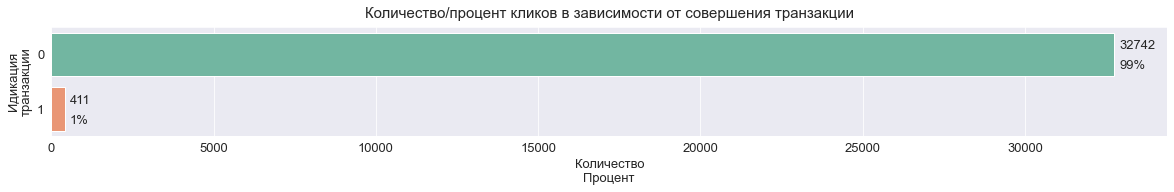

In [10]:
plt.figure(figsize=(20, 2))
plt.title('Количество/процент кликов в зависимости от совершения транзакции', fontsize=15, y=1.03)

ax = sns.countplot(data=df, y='transaction_done')

plt.xlabel('Количество\nПроцент')
plt.ylabel('Идикация\nтранзакции')

total = len(df)
for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height()/1.3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height()/3.2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center') 

Для порядка преобразуем тип данных в столбце `transaction_done` в целочисленный 

In [11]:
df['transaction_done'] = df['transaction_done'].astype('int')

### Объединение данных по источнику

Согласно исходным данным источник определяется связкой `source + medium`, cохраним её отдельный столбец `source_medium`

In [12]:
df['source_medium'] = df['source']+'_'+df['medium']

Далее отдельно столбцы `source` и `medium` не понадобятся. Удалим их.

In [13]:
df = df.drop(['source', 'medium'], axis=1)

### Выбор пользователей, совершивших транзакцию

Сохраним массив пользователей, совершивших транзакцию, в отдельную переменную. 

In [14]:
visitor_filter = df[df['transaction_done'] == 1]['full_visitor_id'].unique()

Оставим в датасете только пользователей, совершивших транзакцию

In [15]:
df = df[df['full_visitor_id'].isin(visitor_filter)]

In [16]:
df.head()

,transaction_id,full_visitor_id,visit_number,transaction_done,source_medium
32,NaN,3694234028523165868,112,0,(direct)_(none)
282,NaN,9026840718082010040,33,0,(direct)_(none)
320,NaN,5960127137243713650,8,0,(direct)_(none)
412,NaN,1973770164859106217,2,0,(direct)_(none)
413,ORD201707051779,1973770164859106217,2,1,(direct)_(none)


### Сортировка датасета

Отсортируем датасет по пользователю и номеру визита

In [17]:
df = df.sort_values(by=['full_visitor_id','visit_number'], ascending=True).reset_index(drop=True)

In [18]:
df.head(7)

,transaction_id,full_visitor_id,visit_number,transaction_done,source_medium
0,NaN,670722016498267,1,0,(direct)_(none)
1,ORD201707102597,670722016498267,1,1,(direct)_(none)
2,NaN,670722016498267,2,0,(direct)_(none)
3,NaN,14262055593378383,4,0,(direct)_(none)
4,ORD201707031910,14262055593378383,4,1,(direct)_(none)
5,NaN,14262055593378383,5,0,(direct)_(none)
6,NaN,16925875208939543,6,0,sites.google.com_referral


Проверим, возрастают ли монотонно по пользователям значения в столбце `visit_number`

In [19]:
mono_time = [df[df['full_visitor_id']==i]['visit_number'].is_monotonic_increasing for i in df['full_visitor_id'].unique()]

In [20]:
if pd.Series(mono_time).unique() == True:
    print (color.BOLD+color.OKGREEN+'Номера визитов пользователя упорядоченны по возрастанию')
else:
    print (color.BOLD+color.FAIL+'Номера визитов пользователя не упорядоченны по возрастанию')

Номера визитов пользователя упорядоченны по возрастанию


### Заполнение пропусков

Заполним пропуски в столбце `transaction_id` ближайшим следующим значением

In [21]:
df['transaction_id'] = df['transaction_id'].fillna(method='backfill')

In [22]:
print(f'Количество пропусков в столбце "transaction_id": {df["transaction_id"].isna().sum()}')

Количество пропусков в столбце "transaction_id": 0


### Объединение данных по пользователю и транзакции

- Добавим столбец `visitor_transaction` для определения цепочек по каждой транзакции.
- Если после транзакции пользователь позже (определяется номером визита) совершал клики, но не совершил транзакцию, такие данные нужно удалить.
- Если пользователь совершал более одной транзакции, то в поле `visitor_transaction` будет иное буквенно-цифровое обозначение, что позволит составить более одной цепочки для одного пользователя.

In [23]:
df.columns

Index(['transaction_id', 'full_visitor_id', 'visit_number', 'transaction_done',
       'source_medium'],
      dtype='object')

In [24]:
df['visitor_transaction'] = df['full_visitor_id'].astype('str')+'_'+df['transaction_id']

In [25]:
df.head(7)

,transaction_id,full_visitor_id,visit_number,transaction_done,source_medium,visitor_transaction
0,ORD201707102597,670722016498267,1,0,(direct)_(none),670722016498267_ORD201707102597
1,ORD201707102597,670722016498267,1,1,(direct)_(none),670722016498267_ORD201707102597
2,ORD201707031910,670722016498267,2,0,(direct)_(none),670722016498267_ORD201707031910
3,ORD201707031910,14262055593378383,4,0,(direct)_(none),14262055593378383_ORD201707031910
4,ORD201707031910,14262055593378383,4,1,(direct)_(none),14262055593378383_ORD201707031910
5,ORD201707112521,14262055593378383,5,0,(direct)_(none),14262055593378383_ORD201707112521
6,ORD201707112521,16925875208939543,6,0,sites.google.com_referral,16925875208939543_ORD201707112521


Удалим ложные данные, получившиеся при заполнении пропусков значениями транзакций от следующего пользователя.

In [26]:
visitor_transaction_filter = df[df['transaction_done'] == 1]['visitor_transaction'].unique()

In [27]:
df = df[df['visitor_transaction'].isin(visitor_transaction_filter)]

In [28]:
df.head(7)

,transaction_id,full_visitor_id,visit_number,transaction_done,source_medium,visitor_transaction
0,ORD201707102597,670722016498267,1,0,(direct)_(none),670722016498267_ORD201707102597
1,ORD201707102597,670722016498267,1,1,(direct)_(none),670722016498267_ORD201707102597
3,ORD201707031910,14262055593378383,4,0,(direct)_(none),14262055593378383_ORD201707031910
4,ORD201707031910,14262055593378383,4,1,(direct)_(none),14262055593378383_ORD201707031910
6,ORD201707112521,16925875208939543,6,0,sites.google.com_referral,16925875208939543_ORD201707112521
7,ORD201707112521,16925875208939543,7,0,(direct)_(none),16925875208939543_ORD201707112521
8,ORD201707112521,16925875208939543,7,1,(direct)_(none),16925875208939543_ORD201707112521


## Результирующие таблицы

### Таблица 1

Таблица `touch_chain`: 
- для каждой транзакции сформирована цепочка касаний

In [29]:
touch_chain = df.groupby('transaction_id')[['source_medium']].agg('=>'.join)
touch_chain.head()

,source_medium
transaction_id,
ORD201707011581,google_organic=>google_organic
ORD201707011628,google_organic=>google_organic
ORD201707011643,google_organic=>google_organic
ORD201707021442,dfa_cpm=>dfa_cpm
ORD201707021449,(direct)_(none)=>(direct)_(none)


### Таблица 2

Топ-10 самых популярных цепочек касаний. Популярность определяется на основе количества таких цепочек в датасете.

In [30]:
top_chain = pd.DataFrame(touch_chain[['source_medium']].value_counts()).rename(columns={0:'count'}).head(10)
top_chain

,count
source_medium,
(direct)_(none)=>(direct)_(none),166
google_organic=>google_organic,70
(direct)_(none)=>(direct)_(none)=>(direct)_(none),60
(direct)_(none)=>(direct)_(none)=>(direct)_(none)=>(direct)_(none),21
google_organic=>google_organic=>google_organic,13
google_cpc=>google_cpc,11
google_organic=>google_organic=>google_organic=>google_organic,10
(direct)_(none)=>(direct)_(none)=>(direct)_(none)=>(direct)_(none)=>(direct)_(none),9
google_cpm=>google_cpm,3


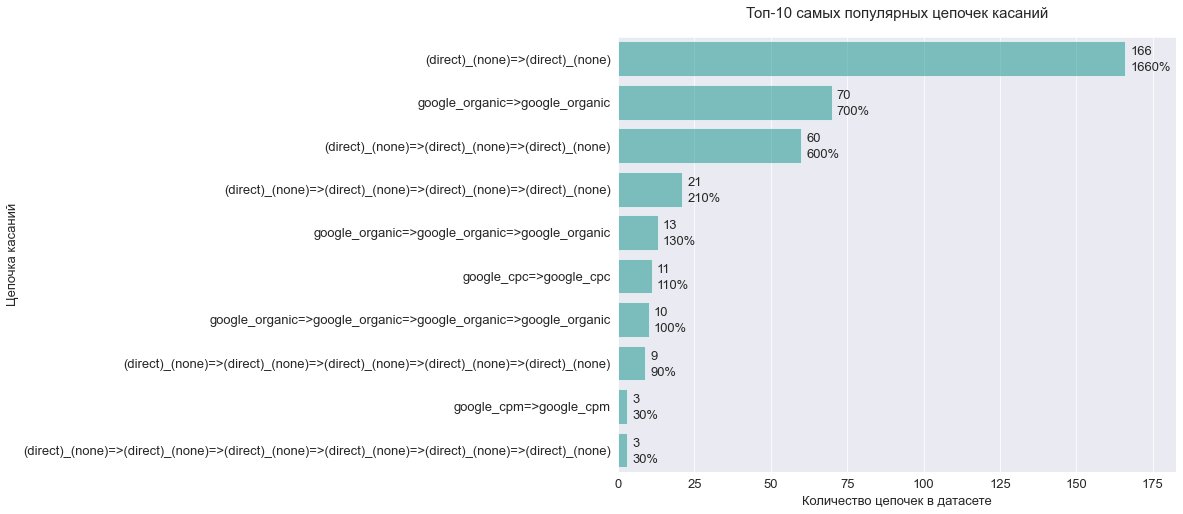

In [31]:
plt.figure(figsize=(10, 8))
plt.title('Топ-10 самых популярных цепочек касаний', fontsize=15, y=1.03)

ax = sns.barplot(data=top_chain.reset_index(),
                 x='count',
                 y='source_medium',
                 color='lightseagreen', alpha=.6)

plt.xlabel('Количество цепочек в датасете')
plt.ylabel('Цепочка касаний')
ax.set_xlim([0, top_chain['count'].max()*1.1])

total = len(top_chain)
for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height()/1.3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height()/3.2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center') ;

## Выгрузка данных

Для удобства работы заказчика с полученными данными выгрузим результаты в формате `xlsx`

In [32]:
writer = pd.ExcelWriter('M:/datasets/chain/chain.xlsx', engine='xlsxwriter')

touch_chain.to_excel(writer, sheet_name='touch_chain')
top_chain.to_excel(writer, sheet_name='top_chain')

writer.save()

## Выводы

Для отдел маркетинга предоставлены данные для определения оптимальная последовательности касаний пользователей для совершения транзакции в интернете.

Выполнено:

- Из датасета ga_sessions BigQuery извлечена таблица с необходимым набором полей и периодом запроса 2 недели.
- Сформирована последовательности источников визитов пользователя, которые привели к транзакции.
- Определен топ-10 самых популярных цепочек касаний на основе количества таких цепочек в датасете.

Работа проведена в Jupiter Notebook, результаты предоставлены заказчику в формате `.xlsx`.